# Data Science Academy

# Projeto de Análise de Dados com Linguagem Python

## Projeto 6 - Regras de Associação e Market Basket Analysis (MBA)

### Pacotes Python Usados no Projeto

In [1]:
!pip install -q efficient_apriori

In [2]:
# Imports
import numpy as np
import pandas as pd
import efficient_apriori
import matplotlib.pyplot as plt
from datetime import datetime
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext watermark
%watermark -a "Leonardo da Silva Neves"

Author: Leonardo da Silva Neves



### Carregando os Dados

In [4]:
# Carregando os Dados
dados_departamentos = pd.read_csv('Cap10/departamentos.csv')
dados_corredores = pd.read_csv('Cap10/corredores.csv')
dados_produtos = pd.read_csv('Cap10/produtos.csv')
dados_pedidos = pd.read_csv('Cap10/pedidos.csv')
dados_transacoes = pd.read_csv('Cap10/transacoes.csv') 


### Análise Exploratória

#### Detalhes do Tamanho de Cada Dataset via Programação

In [5]:
# Total de registros por dataset
conta_arrays = np.array([['dados_departamentos', len(dados_departamentos), dados_departamentos.shape[1]],
                       ['dados_corredores', len(dados_corredores), dados_corredores.shape[1]],
                       ['dados_produtos', len(dados_pedidos), dados_pedidos.shape[1]],
                       ['dados_transacoes', len(dados_transacoes), dados_transacoes.shape[1]]])

In [6]:
# Converte o array em dataframe
contagem = pd.DataFrame(conta_arrays, columns = ['Arquivo', 'Total de Registros', 'Total_Colunas'])

In [7]:
print(contagem)

               Arquivo Total de Registros Total_Colunas
0  dados_departamentos                 21             2
1     dados_corredores                134             2
2       dados_produtos            3421083             7
3     dados_transacoes           32434489             4


In [8]:
# Tabela de Departamentos
dados_departamentos.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
dados_corredores.shape

(134, 2)

In [10]:
# Tabela de Corredores
dados_corredores.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
# Tabela de Produtos
dados_produtos.shape

(49688, 4)

In [12]:
dados_produtos.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
dados_pedidos.shape

(3421083, 7)

In [14]:
# Tabela Pedidos
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [15]:
dados_transacoes.shape

(32434489, 4)

In [16]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Verificando Valores Ausentes

In [17]:
dados_departamentos.isna().sum()

department_id    0
department       0
dtype: int64

In [18]:
dados_corredores.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [19]:
dados_produtos.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [20]:
dados_pedidos.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [21]:
dados_transacoes.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### *Reorganização dos dados*

#### Merge das tabelas

#### O merge só é possível quando existe um relacionamento entre os dados.

Como estratégia escolhi carregar mesclar uma tabela de cada vez.

In [22]:
%%time
dados_transacoes = dados_transacoes.merge(dados_pedidos, on = 'order_id', how = 'left')


CPU times: total: 8.91 s
Wall time: 10.2 s


In [23]:
%%time
dados_transacoes = dados_transacoes.merge(dados_produtos, on = 'product_id', how = 'left')
#dados_transacoes = dados_transacoes.merge(dados_corredores, on = 'aisle_id', how = 'left')
#dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'department_id', how = 'left')

CPU times: total: 12.6 s
Wall time: 15 s


In [24]:
%%time
dados_transacoes = dados_transacoes.merge(dados_corredores, on = 'aisle_id', how = 'left')
#dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'aisle_id', how = 'left')

CPU times: total: 16.7 s
Wall time: 21.2 s


In [25]:
%%time
dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'department_id', how = 'left')

CPU times: total: 7.84 s
Wall time: 8.56 s


In [26]:
# Checando o número de colunas.
len(dados_transacoes.columns.to_list())

15

In [27]:
# Visualização da tabela completa depois do .merge()
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [28]:
%%time
dados_transacoes.isna().sum()

CPU times: total: 7.45 s
Wall time: 7.74 s


order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [29]:
%%time
dados_transacoes.isnull().sum() / len(dados_transacoes) * 100

CPU times: total: 5.83 s
Wall time: 5.9 s


order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Vamos a variável days_since_prior_order por duas razões:

1- O percentual de valores é apenas de 6.4%.

2- Não usaremos a variável com o algorítmo MBA.

Agrupando os dados e preparando o dataset com todas as transações. Usaremos os dados para aplicar o algorítmo a priori mais tarde.

In [30]:
%%time
df = pd.DataFrame(dados_transacoes.groupby('order_id')['product_id'])

CPU times: total: 3min 8s
Wall time: 3min 12s


In [32]:
df.shape

(3214874, 2)

In [33]:
df.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [34]:
# Lista
prod = []

In [37]:
%%time
for i in range(len(df[0])):
    prod.append(list(df.iloc[i][1]))

CPU times: total: 2min 45s
Wall time: 2min 48s


In [38]:
# Preparar o dataframe
transacoes = pd.DataFrame({'Id_Pedido':df[0], 'Produtos': prod})

In [39]:
transacoes.head(10)

,Id_Pedido,Produtos
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


## Análise Estatística Descritiva

### 1 -  Qual o número de pedidos mais frequênte entre os usuários?

In [41]:
# Visualizando uma amostra aleatória de dados
dados_pedidos.sample(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1295559,1488567,77915,prior,6,5,10,3.0
32288,555567,1988,prior,5,6,10,7.0
81817,1517561,5000,prior,31,1,14,7.0
3317454,3280416,199971,test,4,0,14,24.0
2197242,968497,132282,prior,18,0,16,7.0
2808665,3344343,169452,test,6,6,15,30.0
1412649,1111630,84879,prior,3,1,18,30.0
1600562,123506,96093,prior,6,5,9,3.0
2195796,3011637,132201,prior,46,2,23,1.0
435668,436608,26172,prior,15,0,12,7.0


In [43]:
# Agrupar os dados por usuário agregando pelo maior valor de order_number
contagem_maxima_pedido = dados_pedidos.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
contagem_maxima_pedido.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


Compreendendo o código anterior:

order.groupby("user_id"): Este comando agrupa o DataFrame order pela coluna "user_id". Isso significa que todas as linhas com o mesmo valor em user_id são consideradas juntas em um grupo. A operação de agrupamento é preparatória para realizar alguma operação de agregação dentro de cada grupo.

['order_number'].aggregate(np.max): Depois de agrupar os dados por user_id, selecionamos a coluna 'oreder_number' desses grupos. Então, usamos a função aggregate com np.max (que é a função de máximo do NumPy) para calcular o maior valore de 'order_number' dentro de cada grupo. Em outras palavras, para cada usuário, estamos encontrando o maior número de pedidos.

.reset_index(): Este método é usado para resetar o indice do DataFrame. Quando realizamos uma função de agrupamento, o pandas transforma as colunas pelas quais agrupamos (neste caso, user_id) em índices no novo DataFrame. Usar reset_index() move user_id de volta para uma coluna regular e cria um novo índice numérico padrão.

In [44]:
# Frequência de cada valor de número de pedidos
contagem_maxima_pedido = contagem_maxima_pedido.order_number.value_counts()
contagem_maxima_pedido.head()

order_number
4    23986
5    19590
6    16165
7    13850
8    11700
Name: count, dtype: int64

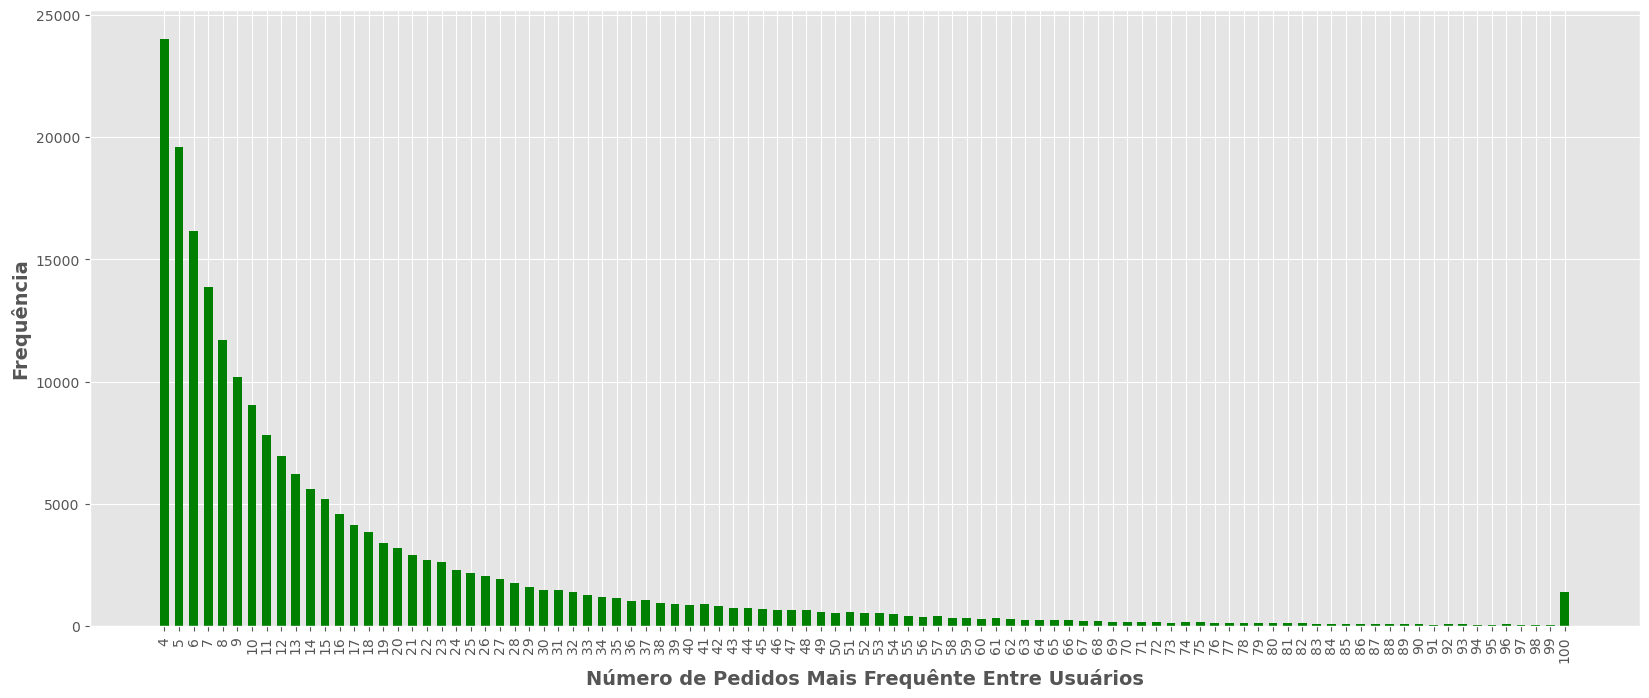

In [48]:
# Plotando os dados no gráfico.
plt.style.use('ggplot')
plt.figure(figsize=(20,8))
plt.bar(contagem_maxima_pedido.index, contagem_maxima_pedido.values, color = 'green', width = 0.6)
plt.xticks(contagem_maxima_pedido.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.xlabel('Número de Pedidos Mais Frequênte Entre Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

### 2 - Qual dia da semana tem o maior número de pedidos?

In [49]:
# (dow - day of the week)
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [52]:
# Contagem de frequência (ocorrência) de cada valor de order_dow
dados_pedidos.order_dow.value_counts()

order_dow
0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: count, dtype: int64

Preparando x e y para o gráfico no formato de lista Python.

In [53]:
# Índice para os dias da semana
x = [0, 1, 2, 3, 4, 5, 6]

In [56]:
# Frequência de pedidos pelo índice (dia da semana)
y = dados_pedidos['order_dow'].value_counts().sort_index().tolist()
y

[600905, 587478, 467260, 436972, 426339, 453368, 448761]

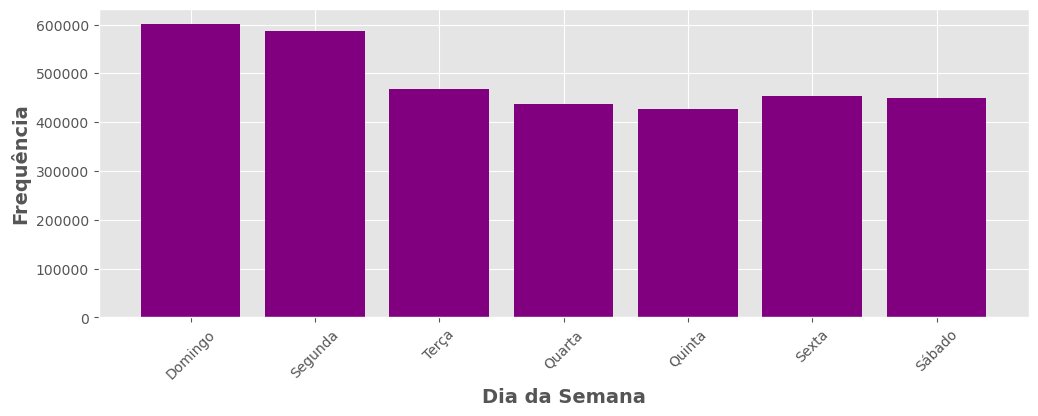

In [58]:
#Plot
plt.figure(figsize=(12,4))
plt.bar(x, y, color = 'purple')
plt.xlabel('Dia da Semana', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.xticks(x, ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 45)
plt.show()